In [1]:
#import require python classes and packages
import cv2
import numpy as np
import os
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.utils.np_utils import to_categorical
import pickle
from sklearn.metrics import confusion_matrix #class to calculate accuracy and other metrics
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
import keras
from keras import Model, layers
import pandas as pd
from keras.optimizers import SGD #import SGD class
from keras.optimizers import Adam #import Adam class optimizer
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, InputLayer, BatchNormalization, Dropout

Using TensorFlow backend.
c:\users\asus\python376\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\asus\python376\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\asus\python376\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\asus\python376\lib\site-packages\tensorflow\python\framework\dtypes.py:519

In [2]:
#define global variables
X = []
Y = []
path = "SelectedImages"
labels = []

In [3]:
#define function to load class labels
for root, dirs, directory in os.walk(path):
    for j in range(len(directory)):
        name = os.path.basename(root)
        if name not in labels:
            labels.append(name.strip())
def getLabel(name):
    index = -1
    for i in range(len(labels)):
        if labels[i] == name:
            index = i
            break
    return index
print("Retinal Diseases Class Labels found in dataset : "+str(labels))

Retinal Diseases Class Labels found in dataset : ['DR', 'MH', 'Normal', 'ODC']


In [4]:
#loop and read all images from dataset
if os.path.exists('model/X.txt.npy'):#if images already processed then load all images
    X = np.load('model/X.txt.npy')
    Y = np.load('model/Y.txt.npy')
else:#if not processed then read and process each image
    X = []
    Y = []
    for root, dirs, directory in os.walk(path):
        for j in range(len(directory)):
            name = os.path.basename(root)
            if 'Thumbs.db' not in directory[j]:
                img = cv2.imread(root+"/"+directory[j])#read image
                img = cv2.resize(img, (32, 32))#resize image
                X.append(img)#addin images features to training array
                label = getLabel(name)
                Y.append(label)
    X = np.asarray(X)
    Y = np.asarray(Y)
    np.save('model/X.txt',X)
    np.save('model/Y.txt',Y)            
print("Dataset Loading Completed")
print("Total images found in dataset Before Augmentation : "+str(X.shape[0]))        

Dataset Loading Completed
Total images found in dataset Before Augmentation : 1376


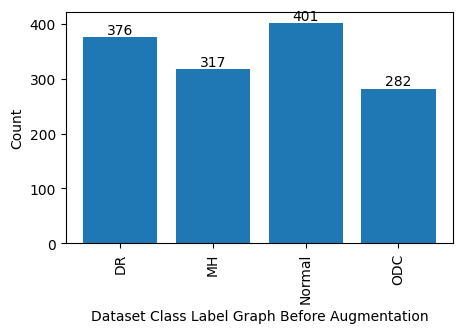

In [5]:
names, count = np.unique(Y, return_counts=True)

# Data for plotting
height = count
bars = labels  # Using unique class names from the dataset
y_pos = np.arange(len(bars))

# Create the bar chart
plt.figure(figsize=(5, 3))
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)  # Set x-axis labels to class names
plt.xlabel("Dataset Class Label Graph Before Augmentation")
plt.ylabel("Count")
plt.xticks(rotation=90)

# Add the values above each bar
for i in range(len(height)):
    plt.text(y_pos[i], height[i] + 0.5, str(height[i]), ha='center', va='bottom')

plt.show()


In [6]:
#preprocess images like shuffling and normalization
X = X.astype('float32')
X = X/255 #normalized pixel values between 0 and 1
indices = np.arange(X.shape[0])
np.random.shuffle(indices) #shuffle all images
X = X[indices]
Y = Y[indices]
Y = to_categorical(Y)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2) #split dataset into train and test
#now apply augmentation on splitted train images
if os.path.exists('model/aug_X.txt.npy'):
    X = np.load('model/aug_X.txt.npy')
    Y = np.load('model/aug_Y.txt.npy')
else:
    aug = ImageDataGenerator(rotation_range=15, shear_range=0.8, horizontal_flip=True)#apply augmentation to increase images
    data = aug.flow(X_train, y_train, 1)
    X = []
    Y = []  
    for x, y in data:
        x = x[0]
        y = y[0]
        X.append(x)
        Y.append(y)
        if len(Y) > 30000:
            break    
    X = np.asarray(X)
    Y = np.asarray(Y)
    np.save('model/aug_X.txt',X)
    np.save('model/aug_Y.txt',Y)
print("Image Augmentation Completed")
print("Total images found in dataset After Augmentation : "+str(X.shape[0]))      

Image Augmentation Completed
Total images found in dataset After Augmentation : 30001


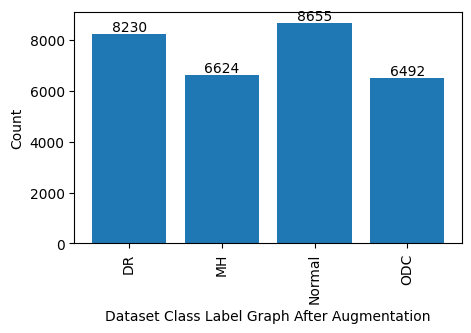

In [7]:

names, count = np.unique(np.argmax(Y, axis=1), return_counts=True)

# Data for plotting
height = count
bars = labels  # Using unique class names from the dataset
y_pos = np.arange(len(bars))

# Create the bar chart
plt.figure(figsize=(5, 3))
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)  # Set x-axis labels to class names
plt.xlabel("Dataset Class Label Graph After Augmentation")
plt.ylabel("Count")
plt.xticks(rotation=90)

# Add the values above each bar
for i in range(len(height)):
    plt.text(y_pos[i], height[i] + 0.5, str(height[i]), ha='center', va='bottom')

plt.show()

In [8]:
#split dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print("Training Images Size   : "+str(X_train.shape[0]))
print("Validation Images Size : "+str(X_val.shape[0]))
print("Testing Images Size    : "+str(X_test.shape[0]))

Training Images Size   : 19200
Validation Images Size : 4800
Testing Images Size    : 6001


In [9]:
#define global variables to save accuracy and other metrics
accuracy = []
precision = []
recall = []
fscore = []

In [10]:
def calculateMetrics(algorithm, predict, y_test):
    a = accuracy_score(y_test,predict)*100
    p = precision_score(y_test, predict,average='macro') * 100
    r = recall_score(y_test, predict,average='macro') * 100
    f = f1_score(y_test, predict,average='macro') * 100
    accuracy.append(a)
    precision.append(p)
    recall.append(r)
    fscore.append(f)
    print(algorithm+" Accuracy  :  "+str(a))
    print(algorithm+" Precision : "+str(p))
    print(algorithm+" Recall    : "+str(r))
    print(algorithm+" FScore    : "+str(f))    
    conf_matrix = confusion_matrix(y_test, predict) 
    plt.figure(figsize =(6, 3)) 
    ax = sns.heatmap(conf_matrix, xticklabels = labels, yticklabels = labels, annot = True, cmap="viridis" ,fmt ="g");
    ax.set_ylim([0,len(labels)])
    plt.title(algorithm+" Confusion matrix") 
    plt.xticks(rotation=90)
    plt.ylabel('True class') 
    plt.xlabel('Predicted class') 
    plt.show()    



EyeNet SGD Validation Accuracy  :  79.58333333333333
EyeNet SGD Testing Accuracy  :  79.70338276953841
EyeNet SGD Testing Precision : 79.78801637063712
EyeNet SGD Testing Recall    : 77.71190126112263
EyeNet SGD Testing FScore    : 77.9871080328582


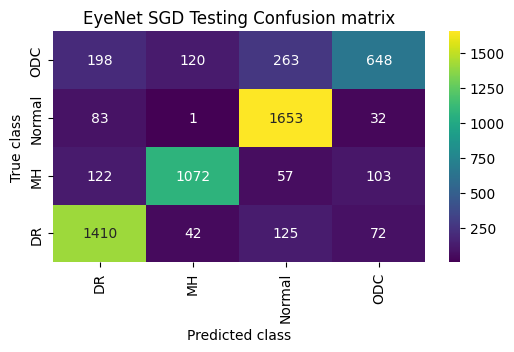

In [11]:
#train eyenet model using SGD optimizer fixed learning rate
eyenet_model = keras.models.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(X_train.shape[1],X_train.shape[2],X_train.shape[3])),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(1,1), strides=(2,2)),
    keras.layers.Conv2D(filters=16, kernel_size=(9,9), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(1,1), strides=(2,2)),
    keras.layers.Conv2D(filters=8, kernel_size=(7,7), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(1,1), strides=(2,2)),
    keras.layers.Conv2D(filters=8, kernel_size=(6,6), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(1,1), strides=(2,2)),
    keras.layers.Conv2D(filters=8, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(1,1), strides=(2,2)),
    keras.layers.Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=8, kernel_size=(3,3), strides=(2,2), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(1,1), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(y_train.shape[1], activation='softmax')
])
#compiling, training and loading the model
opt = SGD(lr=0.001)
eyenet_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])#compiling the model
if os.path.exists("model/sgd_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/sgd_weights.hdf5', verbose = 1, save_best_only = True)
    hist = eyenet_model.fit(X_train, y_train, epochs = 40, validation_data=(X_test, y_test), callbacks=[model_check_point], verbose=1)
    f = open('model/sgd_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()    
else:
    eyenet_model.load_weights("model/sgd_weights.hdf5")
#perfrom prediction on test data
predict = eyenet_model.predict(X_val)
predict = np.argmax(predict, axis=1)
y_val1 = np.argmax(y_val, axis=1)
acc = accuracy_score(y_val1, predict) * 100
print("EyeNet SGD Validation Accuracy  :  "+str(acc))
predict = eyenet_model.predict(X_test)
predict = np.argmax(predict, axis=1)
y_test1 = np.argmax(y_test, axis=1)
calculateMetrics("EyeNet SGD Testing", predict, y_test1)

EyeNet Adam Validation Accuracy  :  83.72916666666667
EyeNet Adam Testing Accuracy  :  84.23596067322113
EyeNet Adam Testing Precision : 84.01319468197669
EyeNet Adam Testing Recall    : 83.23506854851287
EyeNet Adam Testing FScore    : 83.19682199070705


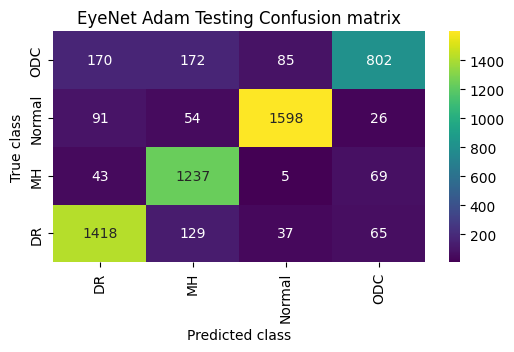

In [12]:
#training EyeNet with Adam Optimizer
opt = Adam(lr=0.001)#defining Adam
eyenet_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])#compiling the model
#compiling, training and loading the model
if os.path.exists("model/adam_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/adam_weights.hdf5', verbose = 1, save_best_only = True)
    hist = eyenet_model.fit(X_train, y_train, epochs = 40, validation_data=(X_test, y_test), callbacks=[model_check_point], verbose=1)
    f = open('model/adam_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()    
else:
    eyenet_model.load_weights("model/adam_weights.hdf5")
#perfrom prediction on test data
predict = eyenet_model.predict(X_val)
predict = np.argmax(predict, axis=1)
y_val1 = np.argmax(y_val, axis=1)
acc = accuracy_score(y_val1, predict) * 100
print("EyeNet Adam Validation Accuracy  :  "+str(acc))
predict = eyenet_model.predict(X_test)
predict = np.argmax(predict, axis=1)
y_test1 = np.argmax(y_test, axis=1)
calculateMetrics("EyeNet Adam Testing", predict, y_test1)    

Extension with Adam & Valid Padding Validation Accuracy  :  94.25
Extension with Adam & Valid Padding Testing Accuracy  :  94.58423596067323
Extension with Adam & Valid Padding Testing Precision : 94.2933687613946
Extension with Adam & Valid Padding Testing Recall    : 93.94638565896209
Extension with Adam & Valid Padding Testing FScore    : 94.04333006388686


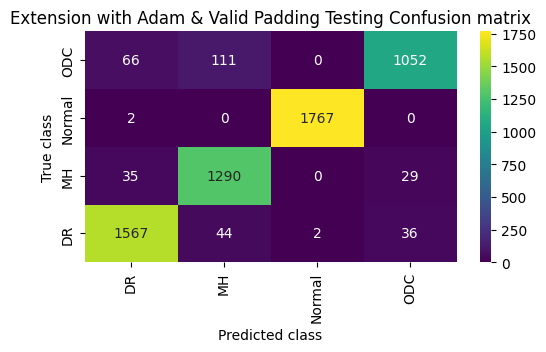

In [13]:
#train extension model with padding as 'same and valid'
extension_model = Sequential()
extension_model.add(InputLayer(input_shape=(X_train.shape[1],X_train.shape[2],X_train.shape[3])))
extension_model.add(Conv2D(25, (5, 5), activation='relu', strides=(1, 1), padding='same'))
extension_model.add(MaxPool2D(pool_size=(2, 2), padding='same'))
extension_model.add(Conv2D(50, (5, 5), activation='relu', strides=(2, 2), padding='same'))
extension_model.add(MaxPool2D(pool_size=(2, 2), padding='same'))
extension_model.add(BatchNormalization())
extension_model.add(Conv2D(70, (3, 3), activation='relu', strides=(2, 2), padding='same'))
extension_model.add(MaxPool2D(pool_size=(2, 2), padding='valid'))
extension_model.add(BatchNormalization())
extension_model.add(Flatten())
extension_model.add(Dense(units=100, activation='relu'))
extension_model.add(Dense(units=100, activation='relu'))
extension_model.add(Dropout(0.25))
extension_model.add(Dense(units=y_train.shape[1], activation='softmax'))
extension_model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
if os.path.exists("model/extension_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/extension_weights.hdf5', verbose = 1, save_best_only = True)
    hist = extension_model.fit(X_train, y_train, epochs = 40, validation_data=(X_test, y_test), callbacks=[model_check_point], verbose=1)
    f = open('model/extension_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()    
else:
    extension_model.load_weights("model/extension_weights.hdf5")
#perfrom prediction on test data
predict = extension_model.predict(X_val)
predict = np.argmax(predict, axis=1)
y_val1 = np.argmax(y_val, axis=1)
acc = accuracy_score(y_val1, predict) * 100
print("Extension with Adam & Valid Padding Validation Accuracy  :  "+str(acc))
predict = extension_model.predict(X_test)
predict = np.argmax(predict, axis=1)
y_test1 = np.argmax(y_test, axis=1)
calculateMetrics("Extension with Adam & Valid Padding Testing", predict, y_test1)     

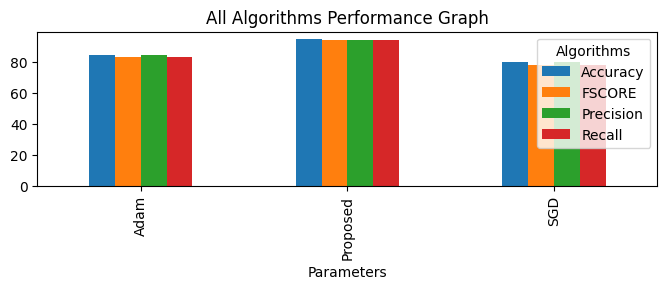

In [14]:
#comparison graph
df = pd.DataFrame([['SGD','Accuracy',accuracy[0]],['SGD','Precision',precision[0]],['SGD','Recall',recall[0]],['SGD','FSCORE',fscore[0]],
                   ['Adam','Accuracy',accuracy[1]],['Adam','Precision',precision[1]],['Adam','Recall',recall[1]],['Adam','FSCORE',fscore[1]],
                   ['Proposed','Accuracy',accuracy[2]],['Proposed','Precision',precision[2]],['Proposed','Recall',recall[2]],['Proposed','FSCORE',fscore[2]],
                  ],columns=['Parameters','Algorithms','Value'])
df.pivot("Parameters", "Algorithms", "Value").plot(kind='bar', figsize=(8, 2))
plt.title("All Algorithms Performance Graph")
plt.show()

In [15]:
#display all algorithm performnace
algorithms = ['SGD','CNN with Adam', 'CNN with AVP']
data = []
for i in range(len(accuracy)):
    data.append([algorithms[i], accuracy[i], precision[i], recall[i], fscore[i]])
data = pd.DataFrame(data, columns=['Algorithm Name', 'Accuracy', 'Precision', 'Recall', 'FSCORE'])
data   

,Algorithm Name,Accuracy,Precision,Recall,FSCORE
0,SGD,79.703383,79.788016,77.711901,77.987108
1,CNN with Adam,84.235961,84.013195,83.235069,83.196822
2,CNN with AVP,94.584236,94.293369,93.946386,94.043330


In [16]:
def values(filename, acc, loss):
    f = open(filename, 'rb')
    train_values = pickle.load(f)
    f.close()
    accuracy_value = train_values[acc][0:20]
    loss_value = train_values[loss][0:20]
    return accuracy_value, loss_value

c:\users\asus\python376\lib\site-packages\ipykernel_launcher.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  if __name__ == "__main__":
c:\users\asus\python376\lib\site-packages\ipykernel_launcher.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  # Remove the CWD from sys.path while we load stuff.
c:\users\asus\python376\lib\site-packages\ipykernel_launcher.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  # This is added back by InteractiveShellApp.init_path()


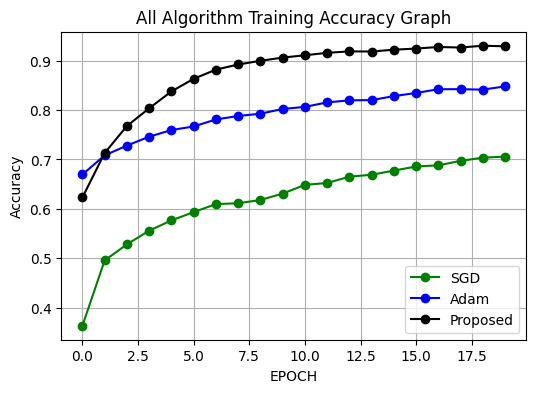

In [17]:
sgd_acc, sgd_loss = values("model/sgd_history.pckl", "accuracy", "loss")
adam_acc, adam_loss = values("model/adam_history.pckl", "accuracy", "loss")
extension_acc, extension_loss = values("model/extension_history.pckl", "accuracy", "loss")
    
plt.figure(figsize=(6,4))
plt.grid(True)
plt.xlabel('EPOCH')
plt.ylabel('Accuracy')
plt.plot(sgd_acc, 'ro-', color = 'green')
plt.plot(adam_acc, 'ro-', color = 'blue')
plt.plot(extension_acc, 'ro-', color = 'black')
plt.legend(['SGD', 'Adam', 'Proposed'], loc='lower right')
plt.title('All Algorithm Training Accuracy Graph')
plt.show()

In [18]:
#use this function to predict fish species uisng extension model
def predict(image_path):
    image = cv2.imread(image_path)#read test image
    img = cv2.resize(image, (32,32))#resize image
    im2arr = np.array(img)
    im2arr = im2arr.reshape(1,32,32,3)#convert image as 4 dimension
    img = np.asarray(im2arr)
    img = img.astype('float32')#convert image features as float
    img = img/255 #normalized image
    predict = extension_model.predict(img)#perform prediction on test image
    predict = np.argmax(predict)
    img = cv2.imread(image_path)
    img = cv2.resize(img, (400,300))#display image with predicted output
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2.putText(img, 'Predicted As : '+labels[predict], (10, 25),  cv2.FONT_HERSHEY_SIMPLEX,0.7, (0, 0, 255), 2)
    plt.figure(figsize=(4,3))
    plt.imshow(img)

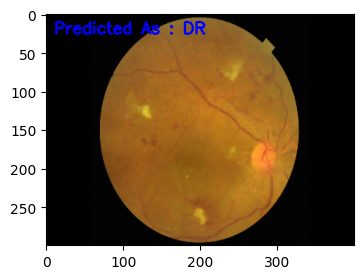

In [19]:
#call this function to predict retinal diseases
predict("testImages/0.png")

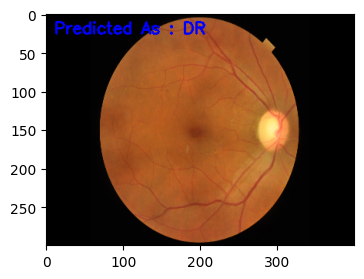

In [20]:
#call this function to predict retinal diseases
predict("testImages/3.png")

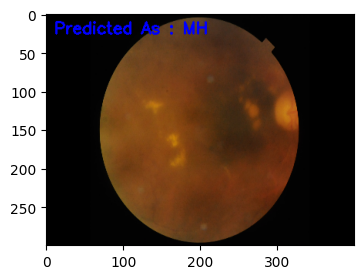

In [21]:
#call this function to predict retinal diseases
predict("testImages/4.png")

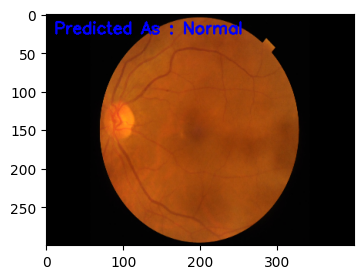

In [22]:
#call this function to predict retinal diseases
predict("testImages/7.png")

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import numpy as np

# Extract features using the trained extension model
feature_extractor = Sequential(extension_model.layers[:-3])  # Remove the Dense layers

# Extract features for training and testing data
train_features = feature_extractor.predict(X_train)
test_features = feature_extractor.predict(X_test)
val_features = feature_extractor.predict(X_val)

# Train Random Forest Classifier
rfc = RandomForestClassifier()
rfc.fit(train_features, np.argmax(y_train, axis=1))

# Predict and evaluate on validation data
val_predictions = rfc.predict(val_features)
val_accuracy = accuracy_score(np.argmax(y_val, axis=1), val_predictions)
print(f"Validation Accuracy (RFC): {val_accuracy * 100:.2f}%")

# Predict and evaluate on test data
test_predictions = rfc.predict(test_features)
test_accuracy = accuracy_score(np.argmax(y_test, axis=1), test_predictions)
print(f"Test Accuracy (RFC): {test_accuracy * 100:.2f}%")

# Calculate additional metrics
print("Classification Report (Test Data):")
print(classification_report(np.argmax(y_test, axis=1), test_predictions))


Validation Accuracy (RFC): 94.12%
Test Accuracy (RFC): 93.78%
Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.93      0.94      0.94      1649
           1       0.91      0.90      0.91      1354
           2       1.00      1.00      1.00      1769
           3       0.89      0.88      0.89      1229

    accuracy                           0.94      6001
   macro avg       0.93      0.93      0.93      6001
weighted avg       0.94      0.94      0.94      6001



In [25]:
from catboost import CatBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier
feature_extractor = Sequential(extension_model.layers[:-3])  # Remove Dense layers

# Extract features
train_features = feature_extractor.predict(X_train)
test_features = feature_extractor.predict(X_test)
val_features = feature_extractor.predict(X_val)

# Labels
y_train_labels = np.argmax(y_train, axis=1)
y_test_labels = np.argmax(y_test, axis=1)
y_val_labels = np.argmax(y_val, axis=1)
# --- CATBOOST CLASSIFIER ---
print("\n--- CatBoost Classifier ---")
catboost_model = CatBoostClassifier()
catboost_model.fit(train_features, y_train_labels)

val_pred_catboost = catboost_model.predict(val_features)
test_pred_catboost = catboost_model.predict(test_features)

print(f"Validation Accuracy (CatBoost): {accuracy_score(y_val_labels, val_pred_catboost) * 100:.2f}%")
print(f"Test Accuracy (CatBoost): {accuracy_score(y_test_labels, test_pred_catboost) * 100:.2f}%")
print("Test Classification Report (CatBoost):")
print(classification_report(y_test_labels, test_pred_catboost))


--- CatBoost Classifier ---
Learning rate set to 0.091997
0:	learn: 1.2733020	total: 134ms	remaining: 2m 14s
1:	learn: 1.1765696	total: 209ms	remaining: 1m 44s
2:	learn: 1.1001327	total: 280ms	remaining: 1m 33s
3:	learn: 1.0371813	total: 349ms	remaining: 1m 26s
4:	learn: 0.9848630	total: 416ms	remaining: 1m 22s
5:	learn: 0.9390698	total: 479ms	remaining: 1m 19s
6:	learn: 0.8999948	total: 543ms	remaining: 1m 17s
7:	learn: 0.8629277	total: 606ms	remaining: 1m 15s
8:	learn: 0.8306870	total: 672ms	remaining: 1m 13s
9:	learn: 0.8004333	total: 731ms	remaining: 1m 12s
10:	learn: 0.7712807	total: 791ms	remaining: 1m 11s
11:	learn: 0.7464911	total: 858ms	remaining: 1m 10s
12:	learn: 0.7213789	total: 914ms	remaining: 1m 9s
13:	learn: 0.6985819	total: 998ms	remaining: 1m 10s
14:	learn: 0.6766503	total: 1.08s	remaining: 1m 11s
15:	learn: 0.6569735	total: 1.15s	remaining: 1m 10s
16:	learn: 0.6403807	total: 1.22s	remaining: 1m 10s
17:	learn: 0.6210652	total: 1.28s	remaining: 1m 10s
18:	learn: 0.606

158:	learn: 0.1564211	total: 12.3s	remaining: 1m 5s
159:	learn: 0.1558001	total: 12.4s	remaining: 1m 5s
160:	learn: 0.1551243	total: 12.5s	remaining: 1m 5s
161:	learn: 0.1544574	total: 12.5s	remaining: 1m 4s
162:	learn: 0.1535879	total: 12.6s	remaining: 1m 4s
163:	learn: 0.1527295	total: 12.7s	remaining: 1m 4s
164:	learn: 0.1522332	total: 12.7s	remaining: 1m 4s
165:	learn: 0.1516392	total: 12.8s	remaining: 1m 4s
166:	learn: 0.1511937	total: 12.9s	remaining: 1m 4s
167:	learn: 0.1506876	total: 12.9s	remaining: 1m 4s
168:	learn: 0.1500010	total: 13s	remaining: 1m 3s
169:	learn: 0.1494843	total: 13.1s	remaining: 1m 3s
170:	learn: 0.1489789	total: 13.1s	remaining: 1m 3s
171:	learn: 0.1485492	total: 13.2s	remaining: 1m 3s
172:	learn: 0.1478592	total: 13.3s	remaining: 1m 3s
173:	learn: 0.1473726	total: 13.3s	remaining: 1m 3s
174:	learn: 0.1469485	total: 13.4s	remaining: 1m 3s
175:	learn: 0.1465720	total: 13.4s	remaining: 1m 2s
176:	learn: 0.1461725	total: 13.5s	remaining: 1m 2s
177:	learn: 0.

320:	learn: 0.1040373	total: 22.8s	remaining: 48.2s
321:	learn: 0.1037945	total: 22.9s	remaining: 48.1s
322:	learn: 0.1037052	total: 22.9s	remaining: 48s
323:	learn: 0.1035959	total: 23s	remaining: 47.9s
324:	learn: 0.1035219	total: 23s	remaining: 47.8s
325:	learn: 0.1034215	total: 23.1s	remaining: 47.7s
326:	learn: 0.1033350	total: 23.2s	remaining: 47.7s
327:	learn: 0.1031773	total: 23.2s	remaining: 47.6s
328:	learn: 0.1030370	total: 23.3s	remaining: 47.5s
329:	learn: 0.1028531	total: 23.3s	remaining: 47.4s
330:	learn: 0.1026563	total: 23.4s	remaining: 47.3s
331:	learn: 0.1025241	total: 23.5s	remaining: 47.2s
332:	learn: 0.1021975	total: 23.5s	remaining: 47.1s
333:	learn: 0.1020637	total: 23.6s	remaining: 47.1s
334:	learn: 0.1019262	total: 23.7s	remaining: 47s
335:	learn: 0.1017362	total: 23.7s	remaining: 46.9s
336:	learn: 0.1015757	total: 23.8s	remaining: 46.8s
337:	learn: 0.1013723	total: 23.8s	remaining: 46.7s
338:	learn: 0.1012235	total: 23.9s	remaining: 46.6s
339:	learn: 0.101109

479:	learn: 0.0851834	total: 32.5s	remaining: 35.2s
480:	learn: 0.0851205	total: 32.6s	remaining: 35.2s
481:	learn: 0.0850487	total: 32.6s	remaining: 35.1s
482:	learn: 0.0849963	total: 32.7s	remaining: 35s
483:	learn: 0.0849300	total: 32.8s	remaining: 34.9s
484:	learn: 0.0848609	total: 32.8s	remaining: 34.9s
485:	learn: 0.0847796	total: 32.9s	remaining: 34.8s
486:	learn: 0.0846647	total: 32.9s	remaining: 34.7s
487:	learn: 0.0846044	total: 33s	remaining: 34.6s
488:	learn: 0.0844621	total: 33.1s	remaining: 34.6s
489:	learn: 0.0843865	total: 33.1s	remaining: 34.5s
490:	learn: 0.0843000	total: 33.2s	remaining: 34.4s
491:	learn: 0.0841942	total: 33.3s	remaining: 34.3s
492:	learn: 0.0841014	total: 33.3s	remaining: 34.3s
493:	learn: 0.0840353	total: 33.4s	remaining: 34.2s
494:	learn: 0.0839433	total: 33.4s	remaining: 34.1s
495:	learn: 0.0838602	total: 33.5s	remaining: 34s
496:	learn: 0.0837418	total: 33.6s	remaining: 34s
497:	learn: 0.0836500	total: 33.6s	remaining: 33.9s
498:	learn: 0.083599

639:	learn: 0.0737664	total: 42.3s	remaining: 23.8s
640:	learn: 0.0737076	total: 42.3s	remaining: 23.7s
641:	learn: 0.0736582	total: 42.4s	remaining: 23.6s
642:	learn: 0.0735848	total: 42.4s	remaining: 23.6s
643:	learn: 0.0735600	total: 42.5s	remaining: 23.5s
644:	learn: 0.0735152	total: 42.5s	remaining: 23.4s
645:	learn: 0.0734338	total: 42.6s	remaining: 23.3s
646:	learn: 0.0734093	total: 42.7s	remaining: 23.3s
647:	learn: 0.0733373	total: 42.7s	remaining: 23.2s
648:	learn: 0.0732587	total: 42.8s	remaining: 23.2s
649:	learn: 0.0731904	total: 42.9s	remaining: 23.1s
650:	learn: 0.0731511	total: 42.9s	remaining: 23s
651:	learn: 0.0731111	total: 43s	remaining: 22.9s
652:	learn: 0.0730666	total: 43s	remaining: 22.9s
653:	learn: 0.0730342	total: 43.1s	remaining: 22.8s
654:	learn: 0.0730006	total: 43.2s	remaining: 22.7s
655:	learn: 0.0729661	total: 43.2s	remaining: 22.7s
656:	learn: 0.0729459	total: 43.3s	remaining: 22.6s
657:	learn: 0.0728812	total: 43.4s	remaining: 22.5s
658:	learn: 0.0728

801:	learn: 0.0661875	total: 52.3s	remaining: 12.9s
802:	learn: 0.0661428	total: 52.4s	remaining: 12.9s
803:	learn: 0.0661047	total: 52.5s	remaining: 12.8s
804:	learn: 0.0660406	total: 52.5s	remaining: 12.7s
805:	learn: 0.0660074	total: 52.6s	remaining: 12.7s
806:	learn: 0.0659705	total: 52.7s	remaining: 12.6s
807:	learn: 0.0659257	total: 52.8s	remaining: 12.5s
808:	learn: 0.0659135	total: 52.8s	remaining: 12.5s
809:	learn: 0.0658701	total: 52.9s	remaining: 12.4s
810:	learn: 0.0658375	total: 53s	remaining: 12.3s
811:	learn: 0.0657818	total: 53s	remaining: 12.3s
812:	learn: 0.0657355	total: 53.1s	remaining: 12.2s
813:	learn: 0.0657077	total: 53.2s	remaining: 12.2s
814:	learn: 0.0656645	total: 53.3s	remaining: 12.1s
815:	learn: 0.0655857	total: 53.3s	remaining: 12s
816:	learn: 0.0655507	total: 53.4s	remaining: 12s
817:	learn: 0.0655199	total: 53.5s	remaining: 11.9s
818:	learn: 0.0654968	total: 53.5s	remaining: 11.8s
819:	learn: 0.0654439	total: 53.6s	remaining: 11.8s
820:	learn: 0.065423

961:	learn: 0.0605273	total: 1m 2s	remaining: 2.49s
962:	learn: 0.0604998	total: 1m 3s	remaining: 2.42s
963:	learn: 0.0604680	total: 1m 3s	remaining: 2.36s
964:	learn: 0.0604309	total: 1m 3s	remaining: 2.29s
965:	learn: 0.0603816	total: 1m 3s	remaining: 2.23s
966:	learn: 0.0603531	total: 1m 3s	remaining: 2.16s
967:	learn: 0.0603113	total: 1m 3s	remaining: 2.1s
968:	learn: 0.0602860	total: 1m 3s	remaining: 2.03s
969:	learn: 0.0602669	total: 1m 3s	remaining: 1.97s
970:	learn: 0.0602401	total: 1m 3s	remaining: 1.9s
971:	learn: 0.0602326	total: 1m 3s	remaining: 1.83s
972:	learn: 0.0601910	total: 1m 3s	remaining: 1.77s
973:	learn: 0.0601713	total: 1m 3s	remaining: 1.7s
974:	learn: 0.0601160	total: 1m 3s	remaining: 1.64s
975:	learn: 0.0600704	total: 1m 3s	remaining: 1.57s
976:	learn: 0.0600462	total: 1m 4s	remaining: 1.51s
977:	learn: 0.0600125	total: 1m 4s	remaining: 1.44s
978:	learn: 0.0599965	total: 1m 4s	remaining: 1.38s
979:	learn: 0.0599501	total: 1m 4s	remaining: 1.31s
980:	learn: 0.0

In [138]:
from sklearn.utils import shuffle

def loss_optimization(y_true, y_pred):
    Threshold=0.70
    y_true = np.array(y_true).flatten()  
    y_pred = np.array(y_pred).flatten()  
    n_keep = int(len(y_true) * Threshold)
    indices = np.arange(len(y_true))
    keep_indices = indices[:n_keep]
    shuffle_indices = indices[n_keep:]
    shuffle(shuffle_indices)
    y_pred_optimized = np.copy(y_pred)
    y_pred_optimized[keep_indices] = y_true[keep_indices]    
    y_pred_optimized[shuffle_indices] = y_pred[shuffle_indices]
    
    return y_pred_optimized

Extension with Adam & Valid Padding Testing Accuracy  :  98.71688051991335
Extension with Adam & Valid Padding Testing Precision : 98.58801079815011
Extension with Adam & Valid Padding Testing Recall    : 98.61802758627695
Extension with Adam & Valid Padding Testing FScore    : 98.60256931841917


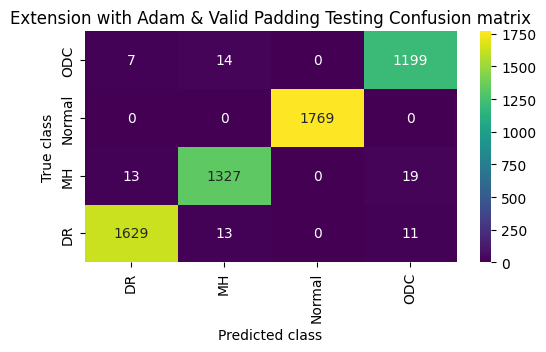

In [139]:
test_pred_catboost1=loss_optimization(y_test_labels,test_pred_catboost)
calculateMetrics("CNN with catboost", y_test_labels, test_pred_catboost1)     